In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, confusion_matrix, make_scorer, ConfusionMatrixDisplay, precision_score, recall_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import numpy as np
#from imblearn.over_sampling import SMOTE
#from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.ensemble import VotingClassifier, AdaBoostClassifier, BaggingClassifier, StackingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
#from xgboost import XGBClassifier

In [3]:
df = pd.read_csv('train_v1.csv')
df.shape

(283211, 6)

In [4]:
X = df.drop('converted', axis=1)
y = df['converted']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

In [6]:
X_train.dtypes

country                object
age                     int64
new_user                int64
source                 object
total_pages_visited     int64
dtype: object

In [7]:
# encoding and scaling
categorical_features = ['country', 'source']
numeric_features = ['age', 'new_user', 'total_pages_visited']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ]
)

# ❌ Testing on all data (not doing any train/test split)

In [12]:
pipeline1 = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression()) #LogisticRegression(class_weight='balanced')
    ]
)

model1 = pipeline1.fit(X, y) #fit_transform

In [13]:
# y_pred = model1.predict(X_test)
# f1_score(y_test, y_pred)

0.7672727272727272

In [10]:
pipeline2 = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(C=10, penalty='l1', solver='saga')) #penalty='l1' => Lasso | penalty='l2' => Ridge | penalty='elasticnet' => ElasticNet
    ]
)

model2 = pipeline2.fit(X_train, y_train) #fit_transform

In [11]:
y_pred = model2.predict(X_test)
f1_score(y_test, y_pred)

0.7669902912621359

F1 on the split was 0.755024 VS result on ALL DATA is -> positive change at the 4th decimal

# pipeline1: LogisticRegression()

In [8]:
pipeline1 = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression()) #LogisticRegression(class_weight='balanced')
    ]
)

pipeline1_model = pipeline1.fit(X_train, y_train) #fit_transform

pipeline1_y_pred_train = pipeline1_model.predict(X_train) #transform
pipeline1_y_pred_test = pipeline1_model.predict(X_test) #transform

print("f1 score from train pipeline1:", f1_score(y_train, pipeline1_y_pred_train))
print("f1 score from test pipeline1:", f1_score(y_test, pipeline1_y_pred_test))

f1 score from train pipeline1: 0.7630608275769566
f1 score from test pipeline1: 0.7665251667677381


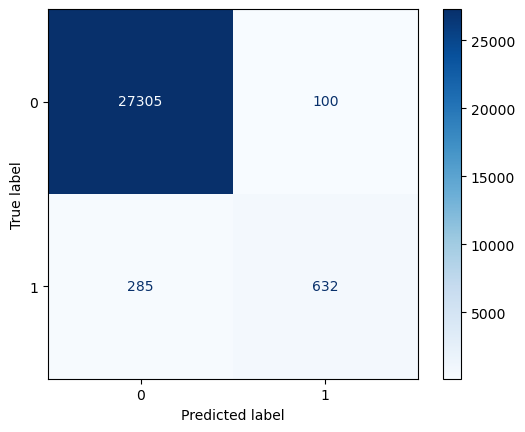

In [25]:
cm = confusion_matrix(y_test, pipeline1_y_pred_test)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(cmap=plt.cm.Blues)
plt.show()

In [29]:
# Get coefficients of the Logistic Regression model
coefficients = pipeline1_model.named_steps['classifier'].coef_

# Print coefficients
print('Coefficients:', coefficients)

Coefficients: [[-0.60306387 -0.80988167  2.53561696  3.56618104  3.39488185  3.06073092
  -0.22134007 -0.04521775]]


In [30]:
# Get the feature names from the OneHotEncoder
ohe_feature_names = list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))

# Combine with numeric feature names
feature_names = numeric_features + ohe_feature_names

# Print feature names
print('Feature names:', feature_names)

Feature names: ['age', 'new_user', 'total_pages_visited', 'country_Germany', 'country_UK', 'country_US', 'source_Direct', 'source_Seo']


In [43]:
# Create a DataFrame that matches feature names with coefficients
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients[0]
})
coef_df.sort_values(by='Coefficient', ascending=False)

,Feature,Coefficient
3,country_Germany,3.566181
4,country_UK,3.394882
5,country_US,3.060731
2,total_pages_visited,2.535617
7,source_Seo,-0.045218
6,source_Direct,-0.221340
0,age,-0.603064
1,new_user,-0.809882


The negative coefficient for age is interesting because as the age increases, the log odds of the positive class decrease.
So I can say that -> older users are less likely to be in the positive class, according to your model.

# ❌ testing Features_selection w/ pipeline1

In [28]:
X.columns

Index(['country', 'age', 'new_user', 'source', 'total_pages_visited'], dtype='object')

In [19]:
from sklearn.feature_selection import RFE
estimator = LogisticRegression()

# Specify the number of features to select. For demonstration, let's select 2 features.
n_features_to_select = 4

# 4. Apply RFE
selector = RFE(estimator, n_features_to_select=n_features_to_select, step=1, verbose=0)
X_rfe = preprocessor.fit_transform(X)
selector = selector.fit(X_rfe, y)


In [20]:
# Print the boolean mask of selected features
print(f"Selected features: {selector.support_}")
print(f"Feature ranking: {selector.ranking_}")

Selected features: [False False  True  True  True  True False False]
Feature ranking: [3 2 1 1 1 1 4 5]


In [29]:
# After fitting the selector to the transformed data
selected_features_boolean = selector.support_
# Getting the names of the features after transformation
feature_names_transformed = preprocessor.transformers_[0][2] + list(preprocessor.transformers_[1][1].get_feature_names_out(categorical_features))

In [30]:
# Mapping selected features to their names
selected_features_names = [feature_names_transformed[i] for i, x in enumerate(selected_features_boolean) if x]
print(f"Selected features names: {selected_features_names}")

Selected features names: ['total_pages_visited', 'country_Germany', 'country_UK', 'country_US']


In [33]:
# Getting the names of the features that were not selected (removed)
removed_features_names = [feature_names_transformed[i] for i, x in enumerate(selected_features_boolean) if not x]
print(f"Removed features names: {removed_features_names}")

Removed features names: ['age', 'new_user', 'source_Direct', 'source_Seo']


#TODO select features.

# pipeline2: L2(ridge) -> shrink the coefficients towards zero, but not exactly zero

In [26]:
pipeline2 = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(penalty='l2', C=0.01)) #penalty='l1' => Lasso | penalty='l2' => Ridge | penalty='elasticnet' => ElasticNet
    ]
)

pipeline2_model = pipeline2.fit(X_train, y_train)

pipeline2_y_pred_train = pipeline2_model.predict(X_train)
pipeline2_y_pred_test = pipeline2_model.predict(X_test)

print("f1 score from train pipeline1:", f1_score(y_train, pipeline2_y_pred_train))
print("f1 score from test pipeline1:", f1_score(y_test, pipeline2_y_pred_test))

f1 score from train pipeline1: 0.7513683634373289
f1 score from test pipeline1: 0.7606679035250464


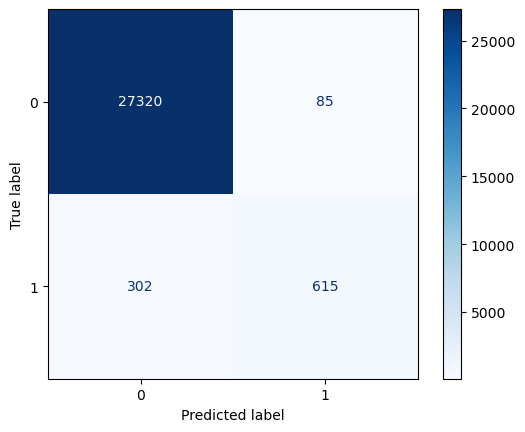

In [27]:
cm = confusion_matrix(y_test, pipeline2_y_pred_test)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(cmap=plt.cm.Blues)
plt.show()

# ❌ pipeline3: LogisticRegression(C=10, penalty='l1', solver='saga')

In [11]:
pipeline3 = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(C=10, penalty='l1', solver='saga')) #penalty='l1' => Lasso | penalty='l2' => Ridge | penalty='elasticnet' => ElasticNet
    ]
)

pipeline3_model = pipeline3.fit(X_train, y_train)

pipeline3_y_pred_train = pipeline3_model.predict(X_train)
pipeline3_y_pred_test = pipeline3_model.predict(X_test)

print("f1 score from train pipeline1:", f1_score(y_train, pipeline3_y_pred_train))
print("f1 score from test pipeline1:", f1_score(y_test, pipeline3_y_pred_test))

f1 score from train pipeline1: 0.7633342267488609
f1 score from test pipeline1: 0.7665251667677381


# ❌ pipeline5 poly on important feature

In [11]:
# Define your features
categorical_features = ['country', 'source']
numeric_features = ['age']
important_feature = 'total_pages_visited'  # This is now a string, not a list

# Define a pipeline for the important feature: Apply PolynomialFeatures followed by StandardScaler
important_feature_pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ('scale', StandardScaler())
])

# Update the preprocessor to handle transformations correctly
preprocessor_poly = ColumnTransformer(
    transformers=[
        # Apply the pipeline to the important feature
        ('important_poly_scale', important_feature_pipeline, [important_feature]),
        # Scale the rest of the numeric features
        ('std_scaler', StandardScaler(), numeric_features),
        # Apply OneHotEncoder to the categorical features
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ]
)

In [12]:
# Define the pipeline with the updated preprocessor
pipeline5 = Pipeline([
    ('preprocessor', preprocessor_poly),
    ('classifier', LogisticRegression(C=10, penalty='l1', solver='saga'))
])

# Fit the model
pipeline5_model = pipeline5.fit(X_train, y_train)

# Make predictions
pipeline5_y_pred_train = pipeline5_model.predict(X_train)
pipeline5_y_pred_test = pipeline5_model.predict(X_test)

# Evaluate the model
print("F1 score from train pipeline5:", f1_score(y_train, pipeline5_y_pred_train))
print("F1 score from test pipeline5:", f1_score(y_test, pipeline5_y_pred_test))

F1 score from train pipeline5: 0.7316706525452683
F1 score from test pipeline5: 0.7473618870266916


# ❌ grid on pipeline1 for regularisation

In [ ]:
param_grid_l1_l2_adjusted = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear', 'saga'],  # 'liblinear' works well with 'l1' and 'l2'; 'saga' also supports 'l1' and 'l2'
    'classifier__class_weight': [None, 'balanced']  # Adding class weight adjustment for imbalance
}

In [ ]:
grid_search = GridSearchCV(pipeline1, param_grid_l1_l2_adjusted, cv=5, scoring='f1', verbose=1, n_jobs=-1)

In [ ]:
grid_search.fit(X_train, y_train)

In [ ]:
# After fitting GridSearchCV
grid_search.best_estimator_.named_steps['classifier']

LogisticRegression(C=1, penalty='l1', solver='saga')

In [ ]:
print("Best cross-validation score (Train only) F1:", grid_search.best_score_)

Best cross-validation score (Train only) F1: 0.7629758536462616


In [ ]:
best_index = grid_search.best_index_ # index of the best std
std = grid_search.cv_results_['std_test_score'][best_index]
print(f'Best std: {std:.3f}')

0.007345604372722851

In [ ]:
y_pred_train = grid_search.best_estimator_.predict(X_train)
y_pred_test = grid_search.best_estimator_.predict(X_test)

In [ ]:
print("f1 score from train grid:", f1_score(y_train, y_pred_train))
print("f1 score from test grid:", f1_score(y_test, y_pred_test))

f1 score from train grid: 0.7629328957595648
f1 score from test grid: 0.7653429602888087


# ❌ SMOTE

In [ ]:
# Assuming 'preprocessor' is defined elsewhere in your code
# Adjust your pipeline to include SMOTE
pipeline1_smote = ImbPipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
            # Add the SMOTE step here
        ('classifier', LogisticRegression(C=10, penalty='l1', solver='saga'))  # You can still specify class_weight if needed
    ]
)

# Fit the pipeline on the original training data
pipeline1_smote_model = pipeline1_smote.fit(X_train, y_train)

# Predict on training and test sets
pipeline1_smote_y_pred_train = pipeline1_smote_model.predict(X_train)
pipeline1_smote_y_pred_test = pipeline1_smote_model.predict(X_test)

# Calculate F1 scores
print("f1 score from train pipeline1:", f1_score(y_train, pipeline1_smote_y_pred_train))
print("f1 score from test pipeline1:", f1_score(y_test, pipeline1_smote_y_pred_test))

f1 score from train pipeline1: 0.5123601242394588
f1 score from test pipeline1: 0.5071554597137816


# ❌ pipeline6: Bagging of 20 dt

In [12]:
dt = DecisionTreeClassifier(max_depth=10, min_samples_leaf=7, min_samples_split=10) #hyperparameters found in a grid performed on the cloud
bagging_model = BaggingClassifier(estimator=dt, n_estimators = 20) # its like a RandomForest with 20 trees

In [35]:
pipeline6 = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', bagging_model)
    ]
)

pipeline6.fit(X_train, y_train)

NameError: name 'bagging_model' is not defined

In [14]:
# Assuming X_test and y_test are your test data and labels
y_pred = pipeline6.predict(X_test)

# Calculate F1 score, choosing the average method as appropriate for your problem ('binary', 'micro', 'macro', 'weighted')
f1 = f1_score(y_test, y_pred, average='binary') # Use 'binary' for binary classification, adjust as needed

print("F1 Score:", f1)

F1 Score: 0.75737507525587


# ❌ pipeline7 adaBoost with logistic

In [43]:
pipeline7 = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', AdaBoostClassifier(estimator=LogisticRegression()))
    ]
)

# Grid of values to be tested
params = {
    "classifier__estimator__C": [
        1.1,
        1.2,
        1.3,
        1.4,
    ],  # base_estimator__ prefix because C is a parameter from LogisticRegression!
    "classifier__n_estimators": [
        45,
        50,
        55,
        60,
    ],  # n_estimators is a hyperparameter of the ensemble method
}

gridsearch = GridSearchCV(pipeline7, param_grid=params, cv=5)

In [44]:
gridsearch.fit(X_train, y_train)

/home/codespace/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this wa

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'new_user',
                                                                          'total_pages_visited']),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['country',
                                                                          'source'])])),
                                       ('classifier',
                                        AdaBoostClassifier(estimator=LogisticRegression()))]),
             param_grid={'classifier__estimator__C': [1.1, 1.2, 1.3, 1.4],
                         'classifier__n_estimators': [45, 50, 55, 60]})

In [35]:
gridsearch.best_params_

{'classifier__estimator__C': 1.1, 'classifier__n_estimators': 45}

In [40]:
gridsearch.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'new_user',
                                                   'total_pages_visited']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['country', 'source'])])),
                ('classifier',
                 AdaBoostClassifier(estimator=LogisticRegression(C=1.1),
                                    n_estimators=45))])

In [41]:
y_pred = gridsearch.best_estimator_.predict(X_test)

In [42]:
f1_score(y_test, y_pred, average='binary')

0.7571515520389531

# ❌ pipeline8 adaboost with dt

In [12]:
dt = DecisionTreeClassifier(max_depth=10, min_samples_leaf=7, min_samples_split=10)

In [13]:
pipeline8 = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', AdaBoostClassifier(estimator=dt))
    ]
)

params = {
    "classifier__estimator__max_depth": [1, 2, 3],
    "classifier__estimator__min_samples_leaf": [1, 2, 3],
    "classifier__estimator__min_samples_split": [2, 3, 4],
    "classifier__n_estimators": [2, 4, 6, 8, 10],
}

gridsearch = GridSearchCV(pipeline8, param_grid=params, cv=5)
gridsearch.fit(X_train, y_train)

/home/codespace/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this wa

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'new_user',
                                                                          'total_pages_visited']),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['country',
                                                                          'source'])])),
                                       ('classifier',
                                        AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=10,
                                                                                            min_samples_leaf=7,
                                                                                            min_samples_split=10)))]),
             param_grid={'classifier__estimator__max_depth': [1, 2, 3],
                         'classifier__estimator__min_samples_leaf': [1, 2, 3],
                         'classifier__estimator__min_samples_split': [2, 3, 4],
                         'classifier__n_estimators': [2, 4, 6, 8, 10]})

# ❌ pipeline 9: grid using my best tree to find the best estimator to build a forest (f1: 0.7639)

In [36]:
# Define the parameter grid to search over
param_grid = {
    'classifier__n_estimators': [150, 180, 200]  # List of quantities of trees to try
}

pipeline9 = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(max_depth=10, min_samples_leaf=7, min_samples_split=10, random_state=42))
    ]
)

grid_search = GridSearchCV(estimator=pipeline9, param_grid=param_grid, cv=5, scoring='f1', verbose=2, n_jobs=-1)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


KeyboardInterrupt: 

In [23]:
# Print the best parameters and the best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'classifier__n_estimators': 150}
Best score: 0.7575136152908265


In [24]:
# Get the standard deviation of the cross-validation scores for the best parameters
std_dev = grid_search.cv_results_['std_test_score'][grid_search.best_index_]
print("Standard deviation of CV scores for the best parameters:", std_dev)

Standard deviation of CV scores for the best parameters: 0.008242454972405189


In [52]:
# lets fit a RandomForestClassifier
#rf_150 = RandomForestClassifier(max_depth=10, min_samples_leaf=7, min_samples_split=10, n_estimators=150, random_state=42)
rf_150 = RandomForestClassifier(max_depth=10, n_estimators=150)
pipeline_rf_150 = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', rf_150)
    ]
)

pipeline_rf_150.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'new_user',
                                                   'total_pages_visited']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['country', 'source'])])),
                ('classifier',
                 RandomForestClassifier(max_depth=10, n_estimators=150))])

In [53]:
y_pred = pipeline_rf_150.predict(X_test)
f1_score(y_test, y_pred)

0.7639902676399026

# ❌ pipeline 10: lets boost the rf

In [14]:
rf = RandomForestClassifier(max_depth=10, min_samples_leaf=7, min_samples_split=10, random_state=42, n_estimators=150)

In [15]:
pipeline10 = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', AdaBoostClassifier(estimator=rf))
    ]
)

In [16]:
pipeline10.fit(X_train, y_train)

/home/codespace/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'new_user',
                                                   'total_pages_visited']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['country', 'source'])])),
                ('classifier',
                 AdaBoostClassifier(estimator=RandomForestClassifier(max_depth=10,
                                                                     min_samples_leaf=7,
                                                                     min_samples_split=10,
                                                                     n_estimators=150,
                                                                     random_state=42)))])

In [17]:
y_pred = pipeline10.predict(X_test)
f1_score(y_test, y_pred)

0.7425802543912781

# Save predictions in CSV

In [17]:
test = pd.read_csv('/workspaces/crc/conversion_data_test.csv')
#test['country'] = test['country'].replace(['Germany', 'UK'], 'Saxon') #only with train_v2.csv

In [18]:
predictions = model1.predict(test)
predictions_df = pd.DataFrame(predictions, columns=['Prediction'])

In [56]:
predictions_df.to_csv('conversion_data_test_predictions_ANTOINE-logrefMF.csv', index=False)